In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import lasio
import pandas as pd
from segysak.segy import segy_loader,segy_writer
from scipy import interpolate
import sys
sys.path.append(r"D:\Farooq_work_2\Pythonscripts")
import Paths
import LASIO
from scipy.interpolate import interp1d
import segy_file_3d
import segy_file
import byte_segy
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from pykrige.rk import RegressionKriging
from sklearn.ensemble import RandomForestRegressor
from pykrige.ok import OrdinaryKriging

C:\ProgramData\Anaconda3\lib\site-packages\segysak\segy\_segy_core.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [147]:
impedance = segy_loader(r"D:\Data\Zamzama-3\cropped_seismic\P-IMPcropped.segy",iline=181,xline=185,cdpx=189,cdpy=193)
dataset = impedance.to_dataframe().reset_index()
seismic = dataset[dataset["data"]!=0.0].dropna(how="any")
seismic

,iline,xline,twt,data,cdp_x,cdp_y
209,382,113,2318.0,12484.578125,365134.0,2949830.0
210,382,113,2320.0,12246.007812,365134.0,2949830.0
211,382,113,2322.0,11257.015625,365134.0,2949830.0
212,382,113,2324.0,9803.640625,365134.0,2949830.0
213,382,113,2326.0,13920.191406,365134.0,2949830.0
...,...,...,...,...,...,...
10914189,626,260,2360.0,11465.535156,369544.0,2957150.0
10914190,626,260,2362.0,10587.007812,369544.0,2957150.0
10914191,626,260,2364.0,10748.875000,369544.0,2957150.0
10914192,626,260,2366.0,10863.097656,369544.0,2957150.0


In [51]:
vpvs = segy_loader(r"D:\Data\Zamzama-3\cropped_seismic\VPVScropped.segy",iline=181,xline=185,cdpx=189,cdpy=193)
dataset1 = vpvs.to_dataframe().reset_index()
seismic_1 = dataset1[dataset1["data"]!=0.0]
seismic_1

  0%|          | 0.00/36.4k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is CDP_X


Converting SEGY:   0%|          | 0.00/36.4k [00:00<?, ? traces/s]

,iline,xline,twt,data,cdp_x,cdp_y
0,382,113,1900.0,NaN,365134.0,2949830.0
1,382,113,1902.0,NaN,365134.0,2949830.0
2,382,113,1904.0,NaN,365134.0,2949830.0
3,382,113,1906.0,NaN,365134.0,2949830.0
4,382,113,1908.0,NaN,365134.0,2949830.0
...,...,...,...,...,...,...
10958803,627,260,2492.0,NaN,369544.0,2957180.0
10958804,627,260,2494.0,NaN,369544.0,2957180.0
10958805,627,260,2496.0,NaN,369544.0,2957180.0
10958806,627,260,2498.0,NaN,369544.0,2957180.0


In [19]:
seismic_1

,iline,xline,twt,data,cdp_x,cdp_y
338,382,113,2318.0,1.750869,365134.0,2949830.0
339,382,113,2319.0,1.594744,365134.0,2949830.0
340,382,113,2320.0,1.560260,365134.0,2949830.0
341,382,113,2321.0,1.855052,365134.0,2949830.0
342,382,113,2322.0,1.664731,365134.0,2949830.0
...,...,...,...,...,...,...
14286429,626,260,2363.0,1.755671,369544.0,2957150.0
14286430,626,260,2364.0,1.948561,369544.0,2957150.0
14286431,626,260,2365.0,1.742434,369544.0,2957150.0
14286432,626,260,2366.0,1.637046,369544.0,2957150.0


In [53]:
logs = Paths.location()

Copy the path and Paste Here : 	D:\Data\Zamzama-2\seismic prestack wells 2 raws
Type the Extensions of File : 	csv


In [113]:
zamzama=[]
for i in logs:
    r = pd.read_csv(i)
    r["SDT"] = (1/r["SDT"])*304800
    r["DT"] =  (1/r["DT"])*304800
    r["P-IMP"] = r["DT"]*r["RHOB"]
    r["S-IMP"] = r["SDT"]*r["RHOB"]
    zamzama.append(r)

In [114]:
IL = [535,428,569,398,445,488,613]
XL = [193,146,193,199,208,199,156]
columns = ["Predicted P-IMP","Predicted VPVS"]

In [124]:
def seismic1(volume,IL,XL,well):
    sample = volume[(volume["iline"]==IL)&(volume["xline"]==XL)].reset_index(drop=True)
    time = well.DPTM
    f = interp1d(sample["twt"],sample["data"])
    data = f(time)
    well = well.loc[time.index,:]
    well["Predicted VPVS"] = data
    cdpx = sample["cdp_x"].iloc[0]
    well["cdpx"] = cdpx*np.ones(len(data))
    cdpy = sample["cdp_y"].iloc[0]
    well["cdpy"] = cdpy*np.ones(len(data))
    return well

In [125]:
LOGS = [0]*len(zamzama)
for i in range(len(IL)):
    LOGS[i]= seismic1(seismic_1,IL[i],XL[i],zamzama[i])

In [126]:
LOGS1 = []
for i in LOGS:
    i = i[["Predicted VPVS"]].dropna(how="any")
    LOGS1.append(i)

In [123]:
# A  = pd.concat(LOGS1)
# B = pd.concat(LOGS1)
A = A.d

In [131]:
DATA = pd.concat([A,B],axis=1)
DATA

,Predicted P-IMP,SW,VCL,DPTM,Predicted VPVS
0,12186.107955,1.0000,0.853700,2092.917225,1.488486
1,12116.057390,1.0000,0.781800,2093.045200,1.487839
2,12046.267376,1.0000,0.718000,2093.172699,1.487195
3,11976.852315,1.0000,0.696900,2093.299513,1.486553
4,11909.088690,1.0000,0.736600,2093.423310,1.485928
...,...,...,...,...,...
539,9670.444948,0.0655,0.039141,2123.640064,1.499999
540,9666.341548,0.0810,0.070200,2123.720736,1.497004
541,9662.274363,0.0971,0.084300,2123.800696,1.494036
542,9657.927624,0.1065,0.084045,2123.886152,1.490863


In [99]:
DATA = pd.concat(LOGS[["Predicted P-IMP"]]).dropna(how="any")
DATA

TypeError: list indices must be integers or slices, not list

In [132]:
def Facies(well):
    well["Facies"]=0
    shale=well[well["VCL"]>0.3].index
    gas=well[(well["VCL"]<=0.3)&(well["SW"]<=0.45)].index
    wet=well[(well["VCL"]<=0.3)&(well["SW"]>0.45)].index
    
    well.loc[shale,"Facies"]=1 #shale
    well.loc[gas,"Facies"]=2 #gas
    well.loc[wet,"Facies"]=3 #wet
    return well

In [133]:
Facies(DATA)

,Predicted P-IMP,SW,VCL,DPTM,Predicted VPVS,Facies
0,12186.107955,1.0000,0.853700,2092.917225,1.488486,1
1,12116.057390,1.0000,0.781800,2093.045200,1.487839,1
2,12046.267376,1.0000,0.718000,2093.172699,1.487195,1
3,11976.852315,1.0000,0.696900,2093.299513,1.486553,1
4,11909.088690,1.0000,0.736600,2093.423310,1.485928,1
...,...,...,...,...,...,...
539,9670.444948,0.0655,0.039141,2123.640064,1.499999,2
540,9666.341548,0.0810,0.070200,2123.720736,1.497004,2
541,9662.274363,0.0971,0.084300,2123.800696,1.494036,2
542,9657.927624,0.1065,0.084045,2123.886152,1.490863,2


<AxesSubplot:xlabel='Predicted P-IMP', ylabel='Predicted VPVS'>

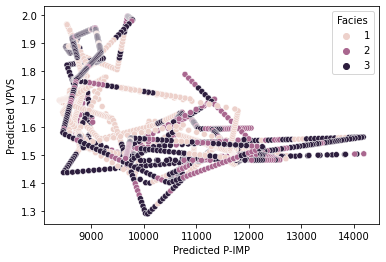

In [135]:
sns.scatterplot(data=DATA,x="Predicted P-IMP",y="Predicted VPVS",hue="Facies")

In [136]:
from sklearn.ensemble import RandomForestClassifier

In [137]:
x = DATA[["Predicted P-IMP","Predicted VPVS"]]
y = DATA["Facies"]

In [138]:
clf = RandomForestClassifier()
clf.fit(x,y)

RandomForestClassifier()

In [140]:
Final = pd.concat([seismic["data"],seismic_1["data"]],axis=1).dropna(how="any")
Final

,data,data
209,12484.578125,1.588490
210,12246.007812,1.490628
211,11257.015625,1.745091
212,9803.640625,1.515815
213,13920.191406,1.502623
...,...,...
10914189,11465.535156,1.486138
10914190,10587.007812,1.552790
10914191,10748.875000,1.573542
10914192,10863.097656,1.543942


In [141]:
predictions = clf.predict_proba(Final)

In [142]:
predictions

array([[0.2 , 0.64, 0.16],
       [0.18, 0.36, 0.46],
       [0.06, 0.25, 0.69],
       ...,
       [0.87, 0.09, 0.04],
       [0.22, 0.05, 0.73],
       [0.1 , 0.33, 0.57]])

In [143]:
predictions1 = clf.predict(Final)

In [144]:
predictions1

array([2, 3, 3, ..., 1, 3, 3], dtype=int64)

In [148]:
seismic_predicted =seismic.copy()
seismic_predicted["data"] = predictions[:,1]

In [149]:
dataset.loc[seismic_predicted.index,"data"]=predictions[:,1]

In [150]:
def SEIS(segy):
    SEGY = segy.set_index(["iline","xline","twt"])
    SEGY= SEGY.to_xarray()
    SEGY.attrs = impedance.attrs
    SEGY["cdp_x"] =SEGY["cdp_x"].mean(dim=["twt"])
    SEGY["cdp_y"] =SEGY["cdp_y"].mean(dim=["twt"])
    SEGY = SEGY.set_coords(["cdp_x", "cdp_y"])
    opt = dict(x="xline",y="twt",add_colorbar=True,robust=True,yincrease=False,cmap="jet")
    inl_sel = [535,428,569,398,445,488,613]
    f, ax = plt.subplots(nrows=len(inl_sel), figsize=(10, 60), sharey=True, constrained_layout=True)
    for i, val in enumerate(inl_sel):
        SEGY.data.sel(iline=val, twt=slice(2000,2400)).plot.imshow(ax=ax[i], **opt)
        ax[i].invert_xaxis()
    return SEGY

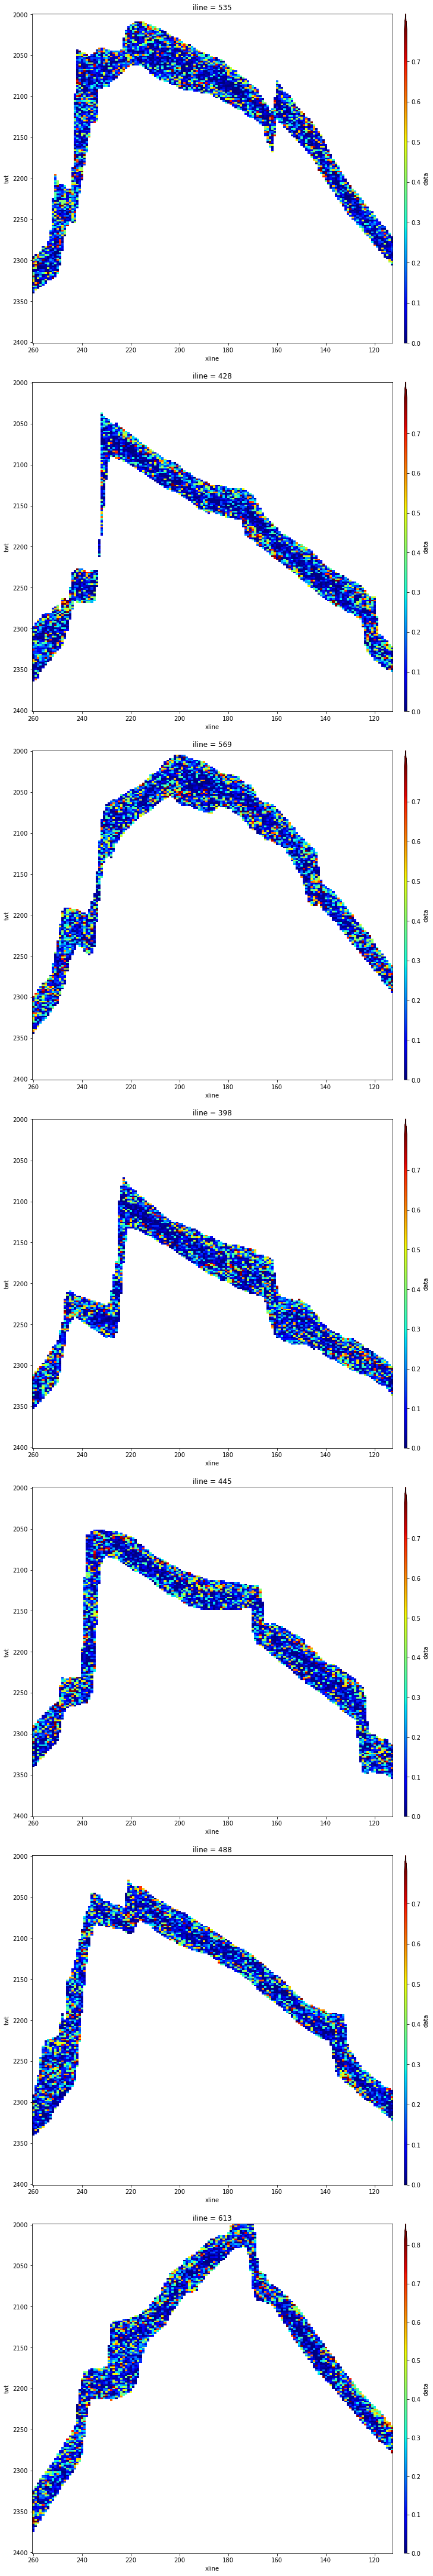

In [151]:
P_IMP = SEIS(dataset)

In [152]:
segy_writer(P_IMP,r"D:\Data\Zamzama-4\seismic\Facies1.segy")

Writing to SEG-Y:   0%|          | 0/36408 [00:00<?, ? traces/s]